# EJERCICIO


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score ,mean_squared_error

import joblib
import warnings

## DEFINICIÓN DEL PROBLEMA


**Vamos a trabajar con un dataframe sobre los datos de propinas que viene en la librería seaborn para intentar predecir que propina dejará una persona a partir de ciertos datos como sexo, importe...**

**Como criterio de evaluación vamos a usar RCME.**


## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS


### OBTENER LOS DATOS


In [2]:
df_tips = sns.load_dataset('tips')

Significado de las columnas:

1. `total_bill`: Esta columna representa el monto total de la factura de una transacción en el restaurante, incluyendo la comida y las bebidas.

2. `tip`: En esta columna se registra la cantidad de propina que se dio en esa transacción.

3. `sex`: Indica el sexo del camarero o camarera que atendió la mesa (por ejemplo, "Male" para masculino y "Female" para femenino).

4. `smoker`: Esta columna indica si los comensales eran fumadores o no fumadores en la mesa (por ejemplo, "Yes" para fumadores y "No" para no fumadores).

5. `day`: Registra el día de la semana en el que se realizó la transacción (por ejemplo, "Thur" para jueves, "Fri" para viernes, "Sat" para sábado y "Sun" para domingo).

6. `time`: Indica si la transacción fue durante el almuerzo o la cena (por ejemplo, "Lunch" para almuerzo y "Dinner" para cena).

7. `size`: Representa el número de comensales en la mesa.


### EXPLORAR LOS DATOS


In [3]:
df_tips.head()


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [5]:
df_tips.isnull().sum()


total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [6]:
df_tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [7]:
categoricas = df_tips.select_dtypes(include=['object', 'bool', 'category'])  
numericas = df_tips.select_dtypes(include=['int64', 'float64']) 


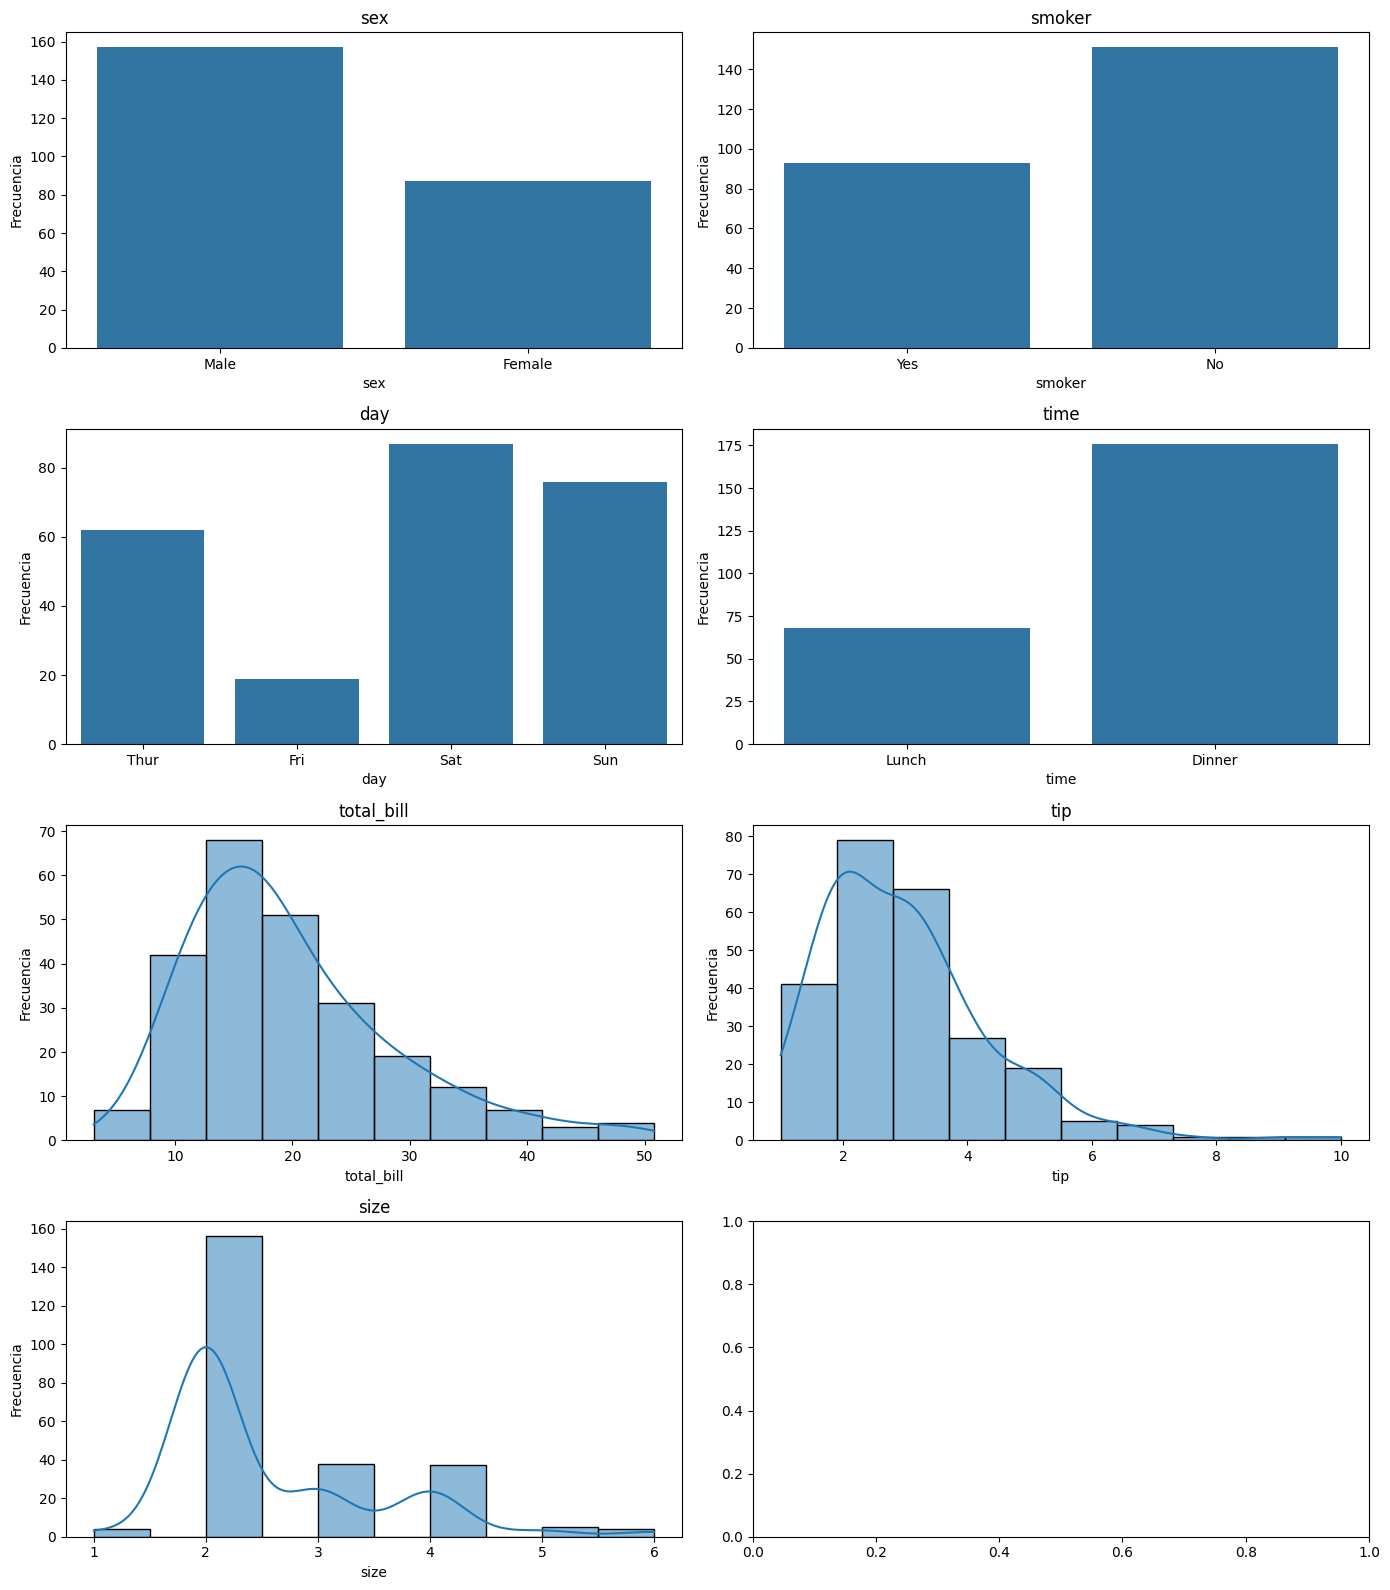

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))  
axes = axes.flatten()  

idx = 0

for columna in categoricas.columns:
    if idx < len(axes): 
        sns.countplot(data=df_tips, x=columna, ax=axes[idx])
        axes[idx].set_title(f'{columna}')
        axes[idx].set_xlabel(columna)
        axes[idx].set_ylabel('Frecuencia')
        idx += 1

# Graficar las variables numéricas
for columna in numericas.columns:
    if idx < len(axes): 
        sns.histplot(data=df_tips, x=columna, bins=10, kde=True, ax=axes[idx])
        axes[idx].set_title(f'{columna}')
        axes[idx].set_xlabel(columna)
        axes[idx].set_ylabel('Frecuencia')
        idx += 1

plt.tight_layout() # Si no pongo esto se solapan 
plt.show()

Hay casi el doble de hombres que de mujeres.
La grán mayoría va a cenar
La mayoría va en fin de semana, sábado y domingo
muy poco los viernes
La mayoría va de dos en dos


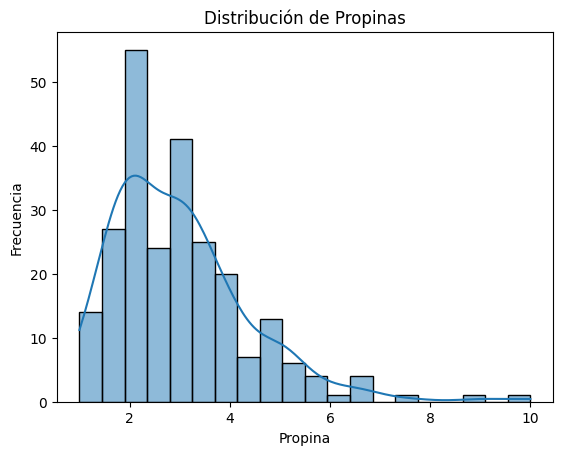

In [9]:
sns.histplot(df_tips['tip'], kde=True, bins=20)
plt.title("Distribución de Propinas")
plt.xlabel("Propina")
plt.ylabel("Frecuencia")
plt.show()


In [10]:
matriz_correlacion = df_tips.corr(numeric_only=True)
matriz_correlacion.style.background_gradient()


,total_bill,tip,size
total_bill,1.000000,0.675734,0.598315
tip,0.675734,1.000000,0.489299
size,0.598315,0.489299,1.000000


Parece que las tres variables estan bastante correlacionadas, tiene sentido que a mayor la cuenta, mayor la propina, y es más facil tener una cuenta más grande si el número de comensales es mayor.


In [11]:
media = df_tips.groupby('total_bill')['tip'].mean().reset_index()
# Crear un nuevo DataFrame con el resultado
resultado_df = pd.DataFrame({
    'total_bill': media['total_bill'],
    'Media propina': media['tip']
})

# Ordenar de manera descendente
resultado_df = resultado_df.sort_values('Media propina', ascending=False).reset_index(drop=True)

print(resultado_df)

     total_bill  Media propina
0         50.81          10.00
1         48.33           9.00
2         39.42           7.58
3         48.27           6.73
4         34.30           6.70
..          ...            ...
224       12.90           1.10
225       16.99           1.01
226       12.60           1.00
227        5.75           1.00
228        3.07           1.00

[229 rows x 2 columns]


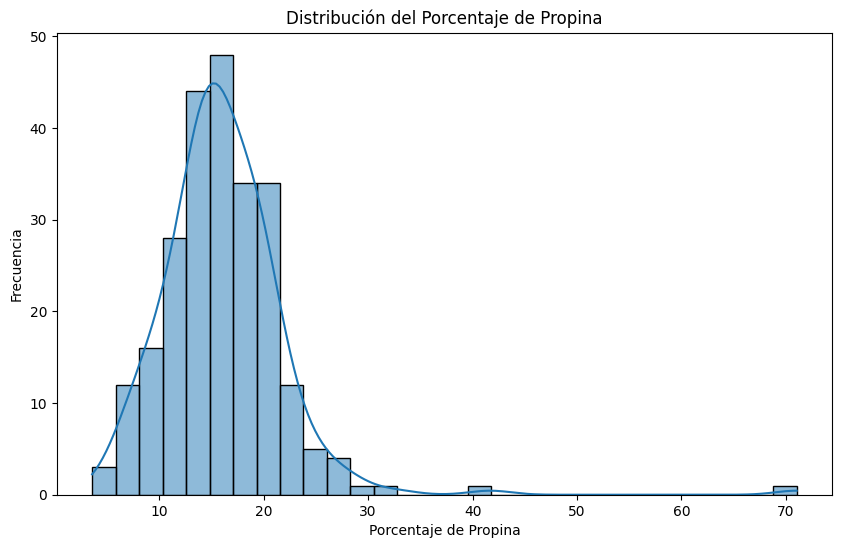

In [ ]:
# Calcular el porcentaje de propina
df_tips['tip_percentage'] = (df_tips['tip'] / df_tips['total_bill']) * 100

plt.figure(figsize=(10, 6))
sns.histplot(df_tips['tip_percentage'], kde=True, bins=30)
plt.title('Distribución del Porcentaje de Propina')
plt.xlabel('Porcentaje de Propina')
plt.ylabel('Frecuencia')
plt.show()

<Axes: xlabel='day', ylabel='tip'>

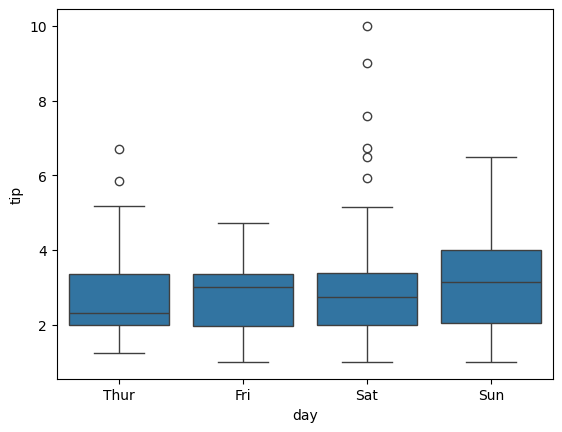

In [ ]:
# Propina por dia
sns.boxplot(x='day', y='tip', data=df_tips)


In [ ]:
# Seleccionar variables features y target
X = df_tips.drop('tip', axis=1)
y = df_tips['tip']  # Target


### DIVIDIR LOS DATOS


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### PREPARAR LOS DATOS


In [27]:
def sex_name(function_transformer, feature_names_in):
    return ['sex']

def time_name(function_transformer, feature_names_in):
    return ['time']

def smoker_name(function_transformer, feature_names_in):
    return ['smoker']

def day_name(function_transformer, feature_names_in):
    return ['day']

def sex_pipeline(X):
    return np.where(X == 'Female', 1, 0)

def time_pipeline(X):
    return np.where(X == 'Lunch', 1, 0)

def smoker_pipeline(X):
    return np.where(X == 'Yes', 1, 0)


pipeline_sexo = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(sex_pipeline, feature_names_out=sex_name)
)

pipeline_hora = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(time_pipeline, feature_names_out=time_name)
)

pipeline_fumador = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(smoker_pipeline, feature_names_out=smoker_name)
)

pipeline_día = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)  
)
preprocessor = ColumnTransformer(
    transformers=[
        ('smoker', pipeline_fumador, ['smoker']),
        ('sex', pipeline_sexo, ['sex']),
        ('time', pipeline_hora, ['time']),
        ('total_bill', SimpleImputer(strategy="mean"), ['total_bill']),
        ('day', pipeline_día, ['day'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)


## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO


No hacer de momento

## OPTIMIZACIÓN DEL MODELO


No hacer de momento


### EVALUACIÓN EN EL CONJUNTO DE PRUEBA


No hacer de momento


## PRESENTACIÓN DE LA SOLUCIÓN


Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:

- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.
